## Setup

In [ ]:
import os
import sys
from pathlib import Path
import matplotlib.pyplot as plt

import random
import numpy as np
import pandas as pd
import isuelogit as isl
import seaborn as sns
from datetime import datetime
import time

import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')

In [2]:
# Path management
main_dir = str(Path(os.path.abspath('')).parents[1])
os.chdir(main_dir)
print('main dir:', main_dir)

sys.path.append(os.path.join(main_dir, 'src'))

main dir: /Users/pablo/github/pesuelogit


In [3]:
%load_ext autoreload
%autoreload 2

# Internal modules
from pesuelogit.visualizations import plot_predictive_performance, plot_heatmap_demands, plot_convergence_estimates
from pesuelogit.models import UtilityParameters, PESUELOGIT, BPRParameters, ODParameters, compute_rr, compute_insample_outofsample_error
from pesuelogit.networks import load_k_shortest_paths, build_tntp_network
from pesuelogit.etl import get_design_tensor, get_y_tensor, add_period_id
from pesuelogit.descriptive_statistics import mse, mape

In [4]:
# Seed for reproducibility
_SEED = 2023
np.random.seed(_SEED)
random.seed(_SEED)
tf.random.set_seed(_SEED)

In [5]:
# To report global runtime
t0_global = time.time()

## Build network

In [6]:
network_name = 'SiouxFalls'
tntp_network = build_tntp_network(network_name=network_name, folderpath=os.getcwd() + "/input/tntp/")

## Read OD matrix

In [7]:
Q = isl.reader.read_tntp_od(network_name=network_name, folderpath=os.getcwd() + "/input/tntp/")
tntp_network.load_OD(Q=Q)

# Assume the historic OD matrix has some random deviation respect to true matrix
Q_historic = isl.factory.random_disturbance_Q(tntp_network.Q.copy(), sd=np.mean(tntp_network.Q) * 0.1)

Reading Q from external file
Matrix Q (24, 24) read in 0.0[s]                        

360600.0 trips were loaded among 528 o-d pairs
Mean of nonzero entries in the original demand matrix:  683.0
Mean absolute difference between the nonzero entries of the noisy and original: 50.6
Approximated proportion change: 7.4%


In [8]:
Q

array([[   0.,  100.,  100.,  500.,  200.,  300.,  500.,  800.,  500.,
        1300.,  500.,  200.,  500.,  300.,  500.,  500.,  400.,  100.,
         300.,  300.,  100.,  400.,  300.,  100.],
       [ 100.,    0.,  100.,  200.,  100.,  400.,  200.,  400.,  200.,
         600.,  200.,  100.,  300.,  100.,  100.,  400.,  200.,    0.,
         100.,  100.,    0.,  100.,    0.,    0.],
       [ 100.,  100.,    0.,  200.,  100.,  300.,  100.,  200.,  100.,
         300.,  300.,  200.,  100.,  100.,  100.,  200.,  100.,    0.,
           0.,    0.,    0.,  100.,  100.,    0.],
       [ 500.,  200.,  200.,    0.,  500.,  400.,  400.,  700.,  700.,
        1200., 1400.,  600.,  600.,  500.,  500.,  800.,  500.,  100.,
         200.,  300.,  200.,  400.,  500.,  200.],
       [ 200.,  100.,  100.,  500.,    0.,  200.,  200.,  500.,  800.,
        1000.,  500.,  200.,  200.,  100.,  200.,  500.,  200.,    0.,
         100.,  100.,  100.,  200.,  100.,    0.],
       [ 300.,  400.,  300.,  400.,

In [9]:
Q_historic

array([[   0.    ,  144.5537,   79.6859,  437.2787,  214.7903,  293.6044,
         428.5503,  966.177 ,  590.1879, 1306.1917,  304.5791,  132.6053,
         479.611 ,  235.1735,  473.3106,  435.5577,  367.3348,   73.5336,
         293.7869,  213.5901,  118.9004,  335.2924,  205.9574,   13.6317],
       [  87.2003,    0.    ,  140.1997,  188.6577,  148.3147,  446.4225,
         282.9357,  427.5012,  165.0748,  658.039 ,  162.392 ,    4.8574,
         431.3015,  155.8781,  199.9468,  360.0108,  129.0665,    0.    ,
         141.1057,  137.2987,    0.    ,   49.2205,    0.    ,    0.    ],
       [  81.1853,  163.1295,    0.    ,  131.9015,    0.    ,  321.3242,
          21.5256,  223.2129,  128.5008,  157.0296,  299.9485,  350.1796,
           0.    ,  182.0746,    1.1181,  147.3698,   89.6384,    0.    ,
           0.    ,    0.    ,    0.    ,    0.    ,  128.3433,    0.    ],
       [ 503.2011,  185.0964,  186.9778,    0.    ,  525.1233,  411.4671,
         477.3681,  681.7321,  701.

## Read paths

In [10]:
load_k_shortest_paths(network=tntp_network, k=3, update_incidence_matrices=True)

Generating at most 3 paths per od
1584 paths were generated among 528 od pairs in 0.3 [s]

1584 paths were loaded in the network
Matrix D (76, 1584) generated in 0.8[s]               

Matrix M (528, 1584) generated in 0.2[s]               

Matrix C (1584, 1584) generated in 0.0[s]               



## Read data

In [11]:
# Synthethic data which was generated under the assumption of path sets of size 2.
df = pd.read_csv(
    main_dir + '/output/network-data/' + tntp_network.key + '/links/' + tntp_network.key + '-link-data.csv')
df

,period,link_key,tt_sd,s,counts,true_counts,true_traveltime,traveltime
0,1,"(0, 1, '0')",0.321988,0.018341,7515.076333,6139.079386,6.002841,7.341932
1,1,"(0, 2, '0')",0.890422,0.603453,7034.842500,5758.656079,4.002199,3.837664
2,1,"(1, 0, '0')",0.588052,0.921806,3773.154711,5495.220725,6.001824,6.191882
3,1,"(1, 5, '0')",0.126596,0.281364,7747.540107,7906.517521,9.849676,9.656309
4,1,"(2, 0, '0')",0.141341,0.834801,8810.477533,6402.514740,4.003361,4.124810
...,...,...,...,...,...,...,...,...
7595,100,"(22, 21, '0')",0.611373,0.570475,9375.990717,10318.046697,14.880809,14.390547
7596,100,"(22, 23, '0')",0.419611,0.377307,6450.125269,7118.491402,3.158053,1.063308
7597,100,"(23, 12, '0')",0.091677,0.284513,7916.670229,10851.756311,16.383733,16.940392
7598,100,"(23, 20, '0')",0.534854,0.202666,11741.293201,10705.049806,13.374851,13.490250


## Exogenous features in utility function

In [12]:
features_Z = ['tt_sd', 's']

## Training and validation sets

In [13]:
n_timepoints = len(df.period.unique())
n_links = len(tntp_network.links)

# Add free flow travel times
df['tt_ff'] = np.tile([link.bpr.tf for link in tntp_network.links], n_timepoints)

traveltime_data = get_design_tensor(y=df['traveltime'], n_links=n_links, n_timepoints = n_timepoints)
flow_data = get_y_tensor(y=df[['counts']], n_links=n_links, n_timepoints = n_timepoints)

df = add_period_id(df)

Y = tf.concat([traveltime_data, flow_data], axis=2)
X = get_design_tensor(Z=df[features_Z + ['period_id']], n_links=n_links, n_timepoints = n_timepoints)

X_train, X_test, Y_train, Y_test = X, None, Y, None

## Configuration

In [14]:
_LR = 1e-1
_BATCH_SIZE = None
# _BATCH_SIZE = 16

# _LR = 5e-1
# _BATCH_SIZE = None

_EPOCHS_PRINT_INTERVAL = 1000
# _EPOCHS_PRINT_INTERVAL = 100

_XTICKS_SPACING = 1000
# _XTICKS_SPACING = 50

_LOSS_METRIC = mse
#_LOSS_METRIC  = btcg_mse
#_LOSS_METRIC  = mnrmse
#_LOSS_METRIC  = nrmse

_LOSS_WEIGHTS ={'od': 1, 'tt': 1, 'flow': 1, 'eq_flow': 1,'ntrips': 0, 'prop_od': 0}


_EPOCHS = {'learning': 5000, 'equilibrium': 500}
# _EPOCHS = {'learning': 200, 'equilibrium': 50}
_RELATIVE_GAP = 1e-5

print(f"loss weights: {_LOSS_WEIGHTS}, epochs: { _EPOCHS}, ' learning rate: {_LR}")

loss weights: {'od': 1, 'tt': 1, 'flow': 1, 'eq_flow': 1, 'ntrips': 0, 'prop_od': 0}, epochs: {'learning': 5000, 'equilibrium': 500}, ' learning rate: 0.1


## Models

In [15]:
list_models = ['equilibrium', 'lue', 'ode', 'ode-nosuelogit', 'lpe',
               'odlue', 'odlulpe', 'odlulptte', 'tvodlulpe']

run_model = dict.fromkeys(list_models,True)

In [16]:
train_results_dfs = {}
val_results_dfs = {}

### Model 1: Equilibrium

Gradient based SUELOGIT
hyperparameters loss function: {'od': 0, 'theta': 0, 'tt': 0, 'flow': 0, 'eq_flow': 1}

Epoch: 0/5000, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
0: train_loss=7.7e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05], lambda eq=1, relative x=0.82, relative gap=1e-05, train flow equilibrium loss=7.7e+07, time: 0.2

Epoch: 1/5000, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
1: train_loss=7.7e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05], lambda eq=1, relative x=0.81, relative gap=0.61, train flow equili

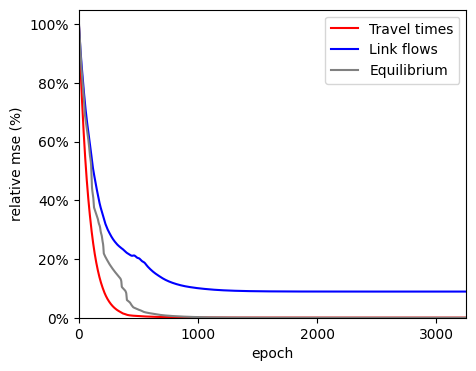

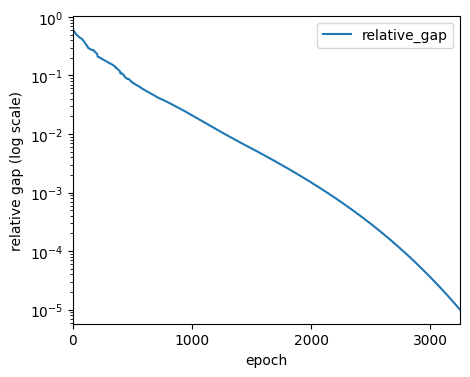


runtime: 509.1 [s]


In [17]:
if run_model['equilibrium']:

    print('Gradient based SUELOGIT')

    # To report runtime
    t0 = time.time()

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': -1, 'tt_sd': -1.3, 's': -3, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': False, 'tt_sd': False, 's': False},
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 1, 'beta': 1},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values= isl.networks.denseQ(Q).flatten(),
                                 # historic_values={0: isl.networks.denseQ(Q_historic).flatten()},
                                 trainable=False)

    suelogit = PESUELOGIT(
        key='suelogit',
        network=tntp_network,
        dtype=tf.float64,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters
    )

    train_results_dfs['suelogit'], val_results_dfs['suelogit'] = suelogit.train(
        X_train, Y_train, X_test, Y_test,
        loss_metric=_LOSS_METRIC,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_weights={'od': 0, 'theta': 0, 'tt': 0, 'flow': 0, 'eq_flow': 1},
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval = _EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = suelogit.split_results(results=train_results_dfs['suelogit'])
    val_results_estimates, val_results_losses = suelogit.split_results(results=val_results_dfs['suelogit'])

    plot_predictive_performance(train_losses=train_results_dfs['suelogit'], val_losses=val_results_dfs['suelogit'],xticks_spacing= _XTICKS_SPACING)

    fig, ax = plot_convergence_estimates(
        estimates=train_results_losses.assign(
            relative_gap = np.abs(train_results_losses['relative_gap']))[['epoch','relative_gap']],
    xticks_spacing= _XTICKS_SPACING)

    ax.set_yscale('log')
    ax.set_ylabel('relative gap (log scale)')

    plt.show()

    print(f'\nruntime: {time.time()-t0:0.1f} [s]')

## Model 2: ODE with historic OD


 ODE: OD estimation with historic OD
hyperparameters loss function: {'od': 1, 'tt': 1, 'flow': 1, 'eq_flow': 1, 'ntrips': 0, 'prop_od': 0}

Epoch: 0/5000, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
0: train_loss=9.1e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=3.9e+03, loss ntrips=0, total trips=[3.6e+05], lambda eq=1, relative x=0.82, relative gap=1e-05, train flow equilibrium loss=7.7e+07, time: 0.1

Epoch: 1/5000, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
1: train_loss=2.2e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=4e+03, loss ntrips=0, total trips=[3.6e+05], lambda eq=0.25, relative x=0.81

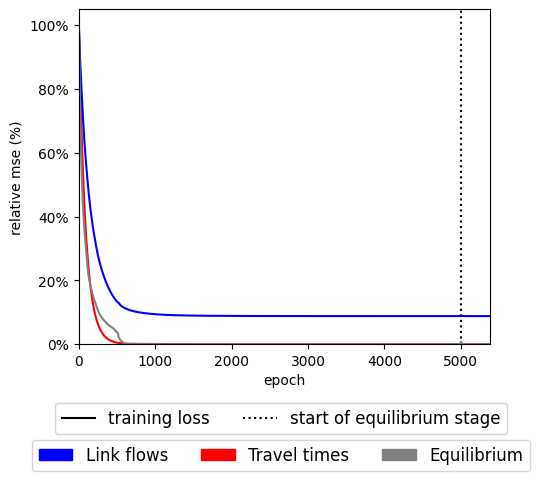

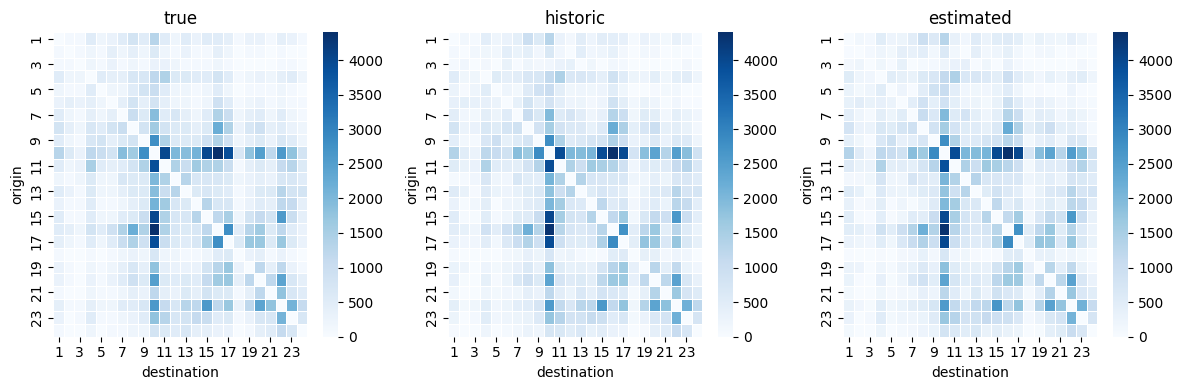

In [19]:
if run_model['ode']:
    print('\n ODE: OD estimation with historic OD')

    # To report runtime
    t0 = time.time()

    # Initialize again the optimizer as there are some decay parameters that are stored in the object and that will
    # affect the next model estimation
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': -1, 'tt_sd': -1.3, 's': -3, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': False, 'tt_sd': False, 's': False},
                                           )

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 # initial_values=tntp_network.q.flatten(),
                                 initial_values= isl.networks.denseQ(Q).flatten(),
                                 historic_values={0: isl.networks.denseQ(Q_historic).flatten()},
                                 # total_trips = {0: np.sum(Q_historic)},
                                 # historic_values={0: tntp_network.q.flatten()},
                                 trainable=True)

    ode = PESUELOGIT(
        key='ode',
        network=tntp_network,
        dtype=tf.float64,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['ode'], val_results_dfs['ode'] = ode.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_metric=_LOSS_METRIC,
        loss_weights=dict(_LOSS_WEIGHTS),
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    plot_predictive_performance(train_losses=train_results_dfs['ode'], val_losses=val_results_dfs['ode'],
                                xticks_spacing=_XTICKS_SPACING,
                                epochs_end_learning_stage=_EPOCHS['learning'],
                                )

    Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(ode.Q).numpy()}

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))

    print(f"\ntheta = {dict(zip(utility_parameters.true_values.keys(), list(ode.theta.numpy())))}")
    print(f"alpha = {ode.alpha: 0.2f}, beta  = {ode.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(ode.q - tntp_network.q.flatten())): 0.2f}")
    print(f"MAPE link flows={mape(actual=ode.observed_flows, predicted = ode.predicted_flow()):0.1f}, "
      f"MAPE travel times={mape(actual=ode.observed_traveltimes, predicted = ode.predicted_traveltime()):0.1f}")
    print(f'runtime: {time.time()-t0:0.1f} [s]')

### Model 3: estimation of link performance parameters (LPE)


LPE: link performance estimation
hyperparameters loss function: {'od': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1, 'ntrips': 0, 'prop_od': 0}

Epoch: 0/5000, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
0: train_loss=9.1e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05], lambda eq=1, relative x=0.82, relative gap=1e-05, train flow equilibrium loss=7.7e+07, time: 0.1

Epoch: 1/5000, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
1: train_loss=2.7e+07, val_loss=0, train_loss tt=8e+02, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.14, avg beta=3.6, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05], lambda eq=0.33, relative x=0.74, relative

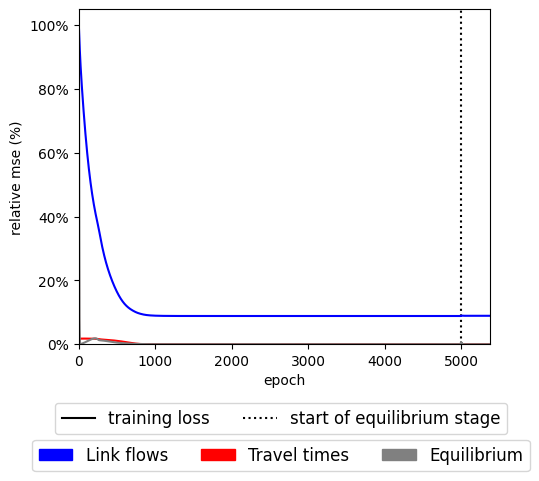

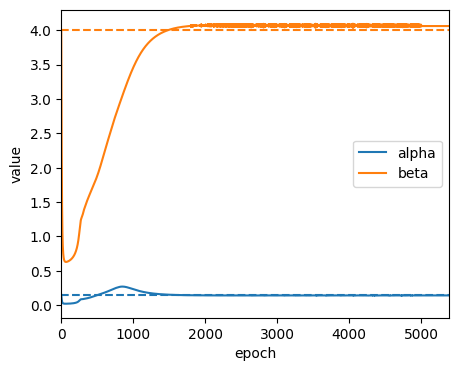


theta = {'tt': array([-1. , -1.3, -3. ])}
alpha =  0.14, beta  =  4.06
Avg abs diff of observed and estimated OD:  0.00
MAPE link flows=9.2, MAPE travel times=16.9
runtime: 809.5 [s]


In [21]:
if run_model['lpe']:
    print('\nLPE: link performance estimation')

    # To report runtime
    t0 = time.time()

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': -1, 'tt_sd': -1.3, 's': -3, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': False, 'tt_sd': False, 's': False},
                                           )

    utility_parameters.random_initializer((0,0),['tt','tt_sd','s'])

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   # initial_values={'alpha': 1, 'beta': 2},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], True),
                                   # trainables={'alpha': False, 'beta': True}
                                   )

    bpr_parameters.random_initializer((0,0),['alpha','beta'])


    od_parameters = ODParameters(key='od',
                                 initial_values= isl.networks.denseQ(Q).flatten(),
                                 # historic_values={0: isl.networks.denseQ(Q).flatten()},
                                 trainable=False)

    lpe = PESUELOGIT(
        key='lpe',
        network=tntp_network,
        dtype=tf.float64,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['lpe'], val_results_dfs['lpe'] = lpe.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_metric=_LOSS_METRIC,
        loss_weights= dict(_LOSS_WEIGHTS, od = 0),
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = lpe.split_results(results=train_results_dfs['lpe'])
    val_results_estimates, val_results_losses = lpe.split_results(results=val_results_dfs['lpe'])

    plot_predictive_performance(train_losses= train_results_losses, val_losses=val_results_dfs['lpe'],
                                epochs_end_learning_stage=_EPOCHS['learning'],
                                xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_estimates[['epoch','alpha','beta']],
                               true_values=lpe.bpr.true_values, xticks_spacing = _XTICKS_SPACING)

    plt.show()

    print(f"\ntheta = {dict(zip(utility_parameters.true_values.keys(), list(lpe.theta.numpy())))}")
    print(f"alpha = {lpe.alpha: 0.2f}, beta  = {lpe.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lpe.q - tntp_network.q.flatten())): 0.2f}")
    print(f"MAPE link flows={mape(actual=lpe.observed_flows, predicted = lpe.predicted_flow()):0.1f}, "
      f"MAPE travel times={mape(actual=lpe.observed_traveltimes, predicted = lpe.predicted_traveltime()):0.1f}")
    print(f'runtime: {time.time()-t0:0.1f} [s]')

### Model 4: Estimation of utility function (LUE)


LUE: Estimation of utility function
hyperparameters loss function: {'od': 0, 'tt': 1, 'flow': 1, 'eq_flow': 1, 'ntrips': 0, 'prop_od': 0}

Epoch: 0/5000, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
0: train_loss=9.1e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05], lambda eq=1, relative x=0.82, relative gap=1e-05, train flow equilibrium loss=7.7e+07, time: 0.1

Epoch: 1/5000, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
1: train_loss=3e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-0.9 -1.4 -3.1], avg rr = 1.56, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=nan, loss ntrips=0, total trips=[3.6e+05], lambda eq=0.33, relative x=0.81, relativ

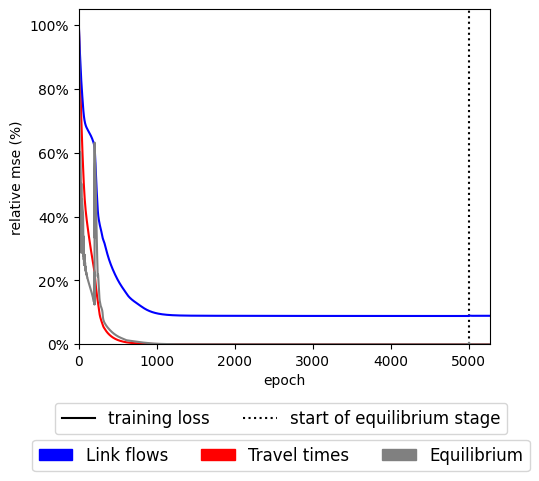

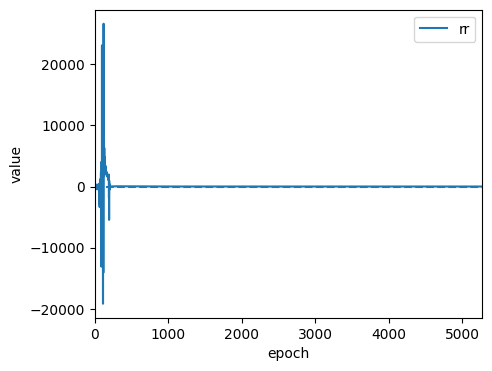

In [22]:
if run_model['lue']:
    print('\nLUE: Estimation of utility function')

    # To report runtime
    t0 = time.time()

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           true_values={'tt': -1, 'tt_sd': -1.3, 's': -3},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': True, 'tt_sd': True, 's': True},
                                           )

    # Utility parameters are set equal to their true values
    utility_parameters.random_initializer((0,0),['tt','tt_sd','s'])
    # utility_parameters.initial_values = dict(utility_parameters.initial_values, tt = -1, c = -1, s = -1)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 1, 'beta': 1},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False))

    od_parameters = ODParameters(key='od',
                                 initial_values= isl.networks.denseQ(Q).flatten(),
                                 # historic_values={0: isl.networks.denseQ(Q_historic).flatten()},
                                 trainable=False)

    lue = PESUELOGIT(
        key='lue',
        network=tntp_network,
        dtype=tf.float64,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters
    )

    train_results_dfs['lue'], val_results_dfs['lue'] = lue.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_metric=_LOSS_METRIC,
        loss_weights= dict(_LOSS_WEIGHTS, od = 0),
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = lue.split_results(results=train_results_dfs['lue'])
    val_results_estimates, val_results_losses = lue.split_results(results=val_results_dfs['lue'])

    plot_predictive_performance(train_losses=train_results_losses, val_losses=val_results_losses,
                                epochs_end_learning_stage=_EPOCHS['learning'],
                                xticks_spacing=_XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_estimates.\
                               assign(rr = train_results_estimates['tt_sd']/train_results_estimates['tt'])[['epoch','rr']],
                               true_values={'rr':lue.utility.true_values['tt_sd']/lue.utility.true_values['tt']},
                                xticks_spacing=_XTICKS_SPACING)


    print(f"\ntheta = {dict(zip(utility_parameters.true_values.keys(), list(np.round(lue.theta.numpy().flatten(),2))))}, "
          f"rr = {train_results_estimates.eval('tt_sd/tt').values[-1]:0.2f}")
    print(f"alpha = {lue.alpha: 0.2f}, beta  = {lue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(lue.q - tntp_network.q.flatten())): 0.2f}")
    print(f"MAPE link flows={mape(actual=lue.observed_flows, predicted = lue.predicted_flow()):0.1f}, "
      f"MAPE travel times={mape(actual=lue.observed_traveltimes, predicted = lue.predicted_traveltime()):0.1f}")
    print(f'runtime: {time.time()-t0:0.1f} [s]')

### Model 5: OD + utility estimation (ODLUE)


ODLUE: OD + utility estimation 
hyperparameters loss function: {'od': 1, 'tt': 1, 'flow': 1, 'eq_flow': 1, 'ntrips': 0, 'prop_od': 0}

Epoch: 0/5000, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
0: train_loss=9.1e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=3.9e+03, loss ntrips=1.8e+03, total trips=[3.6e+05], lambda eq=1, relative x=0.82, relative gap=1e-05, train flow equilibrium loss=7.7e+07, time: 0.1

Epoch: 1/5000, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
1: train_loss=2.2e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-0.9 -1.4 -3.1], avg rr = 1.56, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=4e+03, loss ntrips=1.5e+04, total trips=[3.6e+05], lambda eq=0.25, relative

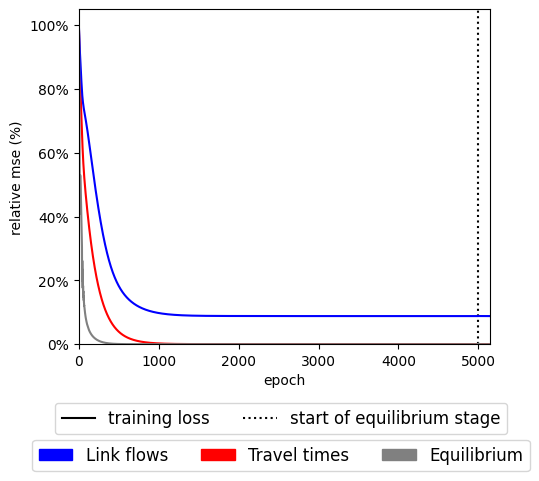

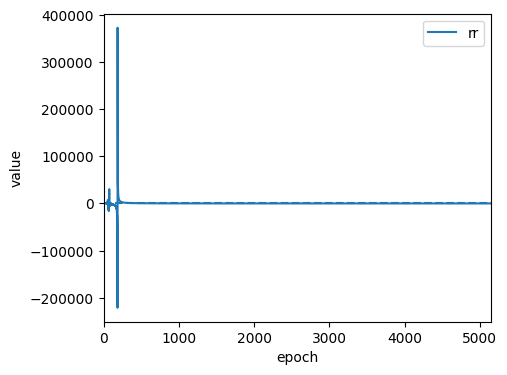

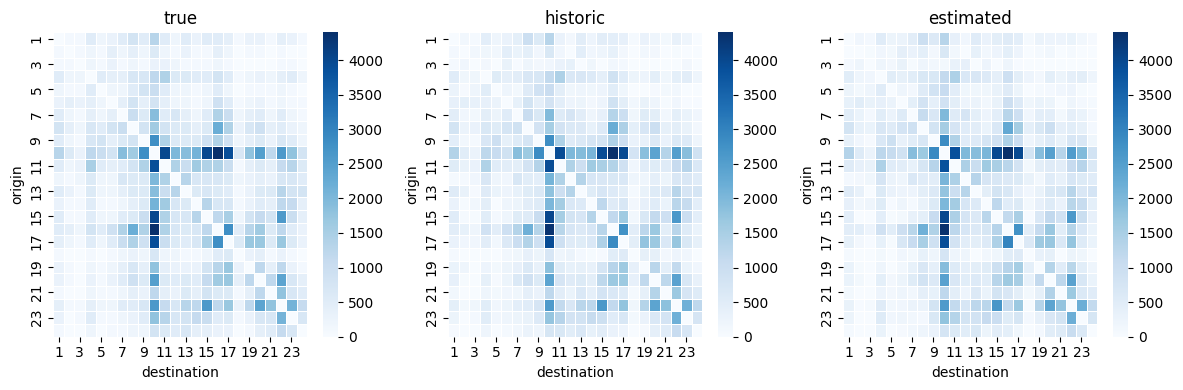


theta = {'tt': -0.54, 'tt_sd': -0.63, 's': -2.46}, rr = 1.17
alpha =  0.15, beta  =  4.00
Avg abs diff of observed and estimated OD:  63.64
MAPE link flows=9.2, MAPE travel times=17.1
runtime: 804.9 [s]


In [23]:
if run_model['odlue']:
    print('\nODLUE: OD + utility estimation ')

    # To report runtime
    t0 = time.time()

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=_LR)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           true_values={'tt': -1, 'tt_sd': -1.3, 's': -3},
                                           # signs={'tt': '-', 'tt_sd': '-', 's': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': True, 'tt_sd': True, 's': True},
                                           )

    utility_parameters.random_initializer((0,0),['tt','tt_sd','s'])
    # utility_parameters.initial_values = dict(utility_parameters.initial_values, tt = -1, c = -1, s = -1)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   trainables=dict.fromkeys(['alpha', 'beta'], False),
                                   )

    od_parameters = ODParameters(key='od',
                                 initial_values= isl.networks.denseQ(Q).flatten(),
                                 historic_values={0: isl.networks.denseQ(Q_historic).flatten()},
                                 total_trips = {0: np.sum(Q_historic)},
                                 trainable=True)

    odlue = PESUELOGIT(
        key='odlue',
        network=tntp_network,
        dtype=tf.float64,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlue'], val_results_dfs['odlue'] = odlue.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_metric=_LOSS_METRIC,
        loss_weights= dict(_LOSS_WEIGHTS),
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = odlue.split_results(results=train_results_dfs['odlue'])
    val_results_estimates, val_results_losses = odlue.split_results(results=val_results_dfs['odlue'])

    plot_predictive_performance(train_losses= train_results_losses, val_losses=val_results_dfs['odlue'],
                                epochs_end_learning_stage=_EPOCHS['learning'],
                                xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_estimates.\
                               assign(rr = train_results_estimates['tt_sd']/train_results_estimates['tt'])[['epoch','rr']],
                               true_values={'rr':odlue.utility.true_values['tt_sd']/odlue.utility.true_values['tt']}, xticks_spacing = _XTICKS_SPACING)

    Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(odlue.Q).numpy()}

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))

    plt.show()

    print(f"\ntheta = {dict(zip(utility_parameters.true_values.keys(), list(np.round(odlue.theta.numpy().flatten(),2))))}, "
          f"rr = {train_results_estimates.eval('tt_sd/tt').values[-1]:0.2f}")
    print(f"alpha = {odlue.alpha: 0.2f}, beta  = {odlue.beta: 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlue.q - tntp_network.q.flatten())): 0.2f}")
    print(f"MAPE link flows={mape(actual=odlue.observed_flows, predicted = odlue.predicted_flow()):0.1f}, "
          f"MAPE travel times={mape(actual=odlue.observed_traveltimes, predicted = odlue.predicted_traveltime()):0.1f}")
    print(f'runtime: {time.time()-t0:0.1f} [s]')

## Model 6: ODLUE + link specific performance parameters (ODLULPE)


ODLULPE: ODLUE + link performance parameters with historic OD matrix
hyperparameters loss function: {'od': 1, 'tt': 1, 'flow': 1, 'eq_flow': 1, 'ntrips': 0, 'prop_od': 0}

Epoch: 0/5000, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
0: train_loss=9.1e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=3.9e+03, loss ntrips=0, total trips=[3.6e+05], lambda eq=1, relative x=0.82, relative gap=1e-05, train flow equilibrium loss=7.7e+07, time: 0.1

Epoch: 1/5000, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
1: train_loss=2e+07, val_loss=0, train_loss tt=8e+02, val_loss tt=0, train_loss flow=1.4e+07, val_loss flow=0, theta = [-0.9 -1.4 -3.1], avg rr = 1.56, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.14, avg beta=3.6, loss prop od=4e+03, loss ntrips=0, total trips=[3.6e+05], l

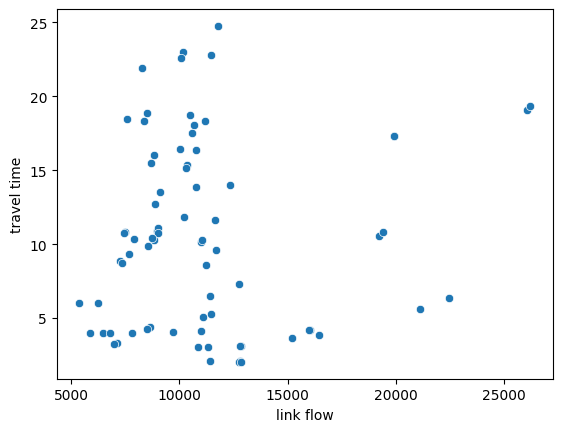

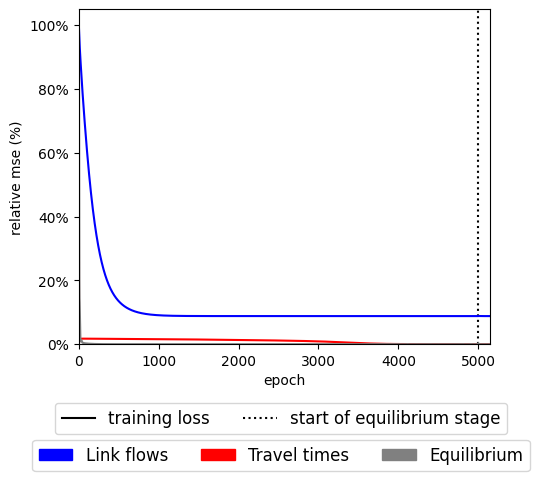

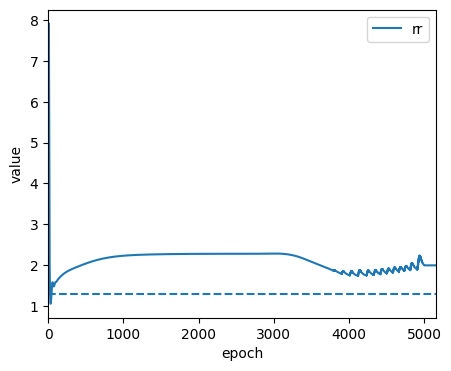

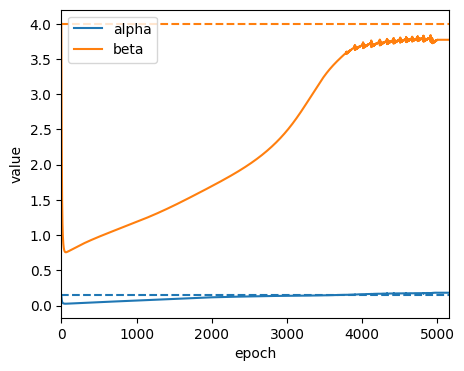

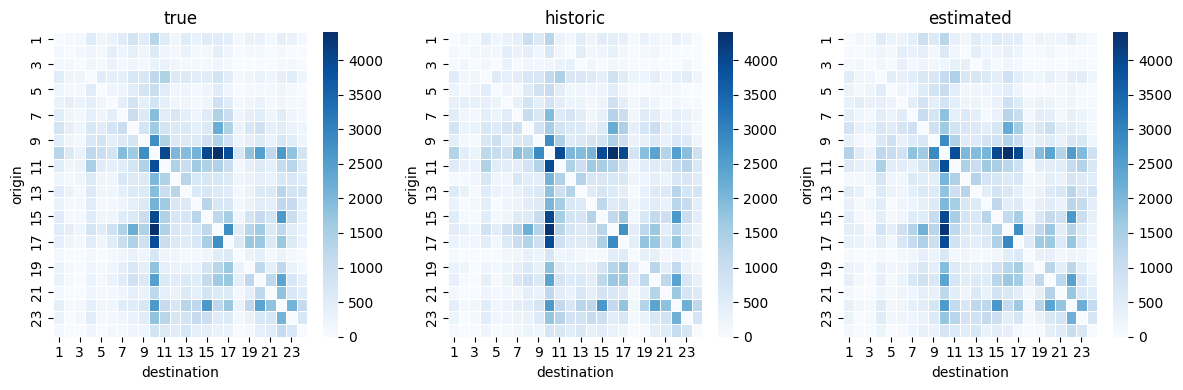


theta = {'tt': -0.65, 'tt_sd': -1.3, 's': -2.43}, rr = 1.99
alpha =  0.18, beta  =  3.77
Avg abs diff of observed and estimated OD:  57.13

MSE
training_error_flow=1257633.9, training_error_traveltime=1.2
insample_error_flow              10583.215820
insample_error_traveltime            0.205921
outofsample_error_flow          130729.101562
outofsample_error_traveltime         0.899181
dtype: float32

MAPE
training_error_flow=9.2, training_error_traveltime=17.8
insample_error_flow             0.786132
insample_error_traveltime       2.971706
outofsample_error_flow          2.648022
outofsample_error_traveltime    5.256680
dtype: float32

runtime: 838.5 [s]


In [24]:
if run_model['odlulpe']:

    print('\nODLULPE: ODLUE + link performance parameters with historic OD matrix')

    # To report runtime
    t0 = time.time()

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=_LR)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 1, 'beta': 2},
                                   # initial_values={'alpha': np.ones_like(tntp_network.links, dtype=np.float32),
                                   #                 'beta': 4 * np.ones_like(tntp_network.links, dtype=np.float32)},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   # initial_values={'alpha': 0.15, 'beta': 4},
                                   trainables={'alpha': True, 'beta':True},
                                   )

    bpr_parameters.random_initializer((0,0),['alpha','beta'])
    # bpr_parameters.random_initializer((-0.15, 0.15), ['alpha']))

    od_parameters = ODParameters(key='od',
                                 initial_values=isl.networks.denseQ(Q).flatten(),
                                 historic_values={0: isl.networks.denseQ(Q_historic).flatten()},
                                 trainable=True)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           true_values={'tt': -1, 'tt_sd': -1.3, 's': -3},
                                           # signs={'tt': '-', 'tt_sd': '-', 's': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': True, 'tt_sd': True, 's': True},
                                           )

    utility_parameters.random_initializer((0,0),['tt','tt_sd','s'])
    # utility_parameters.initial_values = dict(utility_parameters.initial_values, tt = -1, c = -1, s = -1)
    odlulpe = PESUELOGIT(
        key='odlulpe',
        network=tntp_network,
        dtype=tf.float64,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlulpe'], val_results_dfs['odlulpe'] = odlulpe.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_weights= dict(_LOSS_WEIGHTS),
        loss_metric=_LOSS_METRIC,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs=_EPOCHS)

    train_results_estimates, train_results_losses = odlulpe.split_results(results=train_results_dfs['odlulpe'])
    val_results_estimates, val_results_losses = odlulpe.split_results(results=val_results_dfs['odlulpe'])


    sns.scatterplot(data = pd.DataFrame({'link flow': odlulpe.predicted_flow().numpy().flatten(),
                                         'travel time': odlulpe.predicted_traveltime().numpy().flatten(),
                                         # 'capacity': [link.bpr.k for link in odlulpe.network.links]
                                        }),
                                        x = 'link flow', y = 'travel time')

    plot_predictive_performance(train_losses= train_results_losses, val_losses=val_results_dfs['odlulpe'],
                                epochs_end_learning_stage=_EPOCHS['learning'],
                                xticks_spacing = _XTICKS_SPACING)


    plot_convergence_estimates(estimates=train_results_estimates.\
                               assign(rr = train_results_estimates['tt_sd']/train_results_estimates['tt'])[['epoch','rr']],
                               true_values={'rr':odlulpe.utility.true_values['tt_sd']/odlulpe.utility.true_values['tt']},
                               xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_estimates[['epoch','alpha','beta']],
                               true_values=odlulpe.bpr.true_values,
                               xticks_spacing = _XTICKS_SPACING)

    Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(odlulpe.Q).numpy()}

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))

    plt.show()

    print(f"\ntheta = {dict(zip(utility_parameters.true_values.keys(), list(np.round(odlulpe.theta.numpy().flatten(),2))))}, "
          f"rr = {train_results_estimates.eval('tt_sd/tt').values[-1]:0.2f}")
    print(f"alpha = {np.mean(odlulpe.alpha): 0.2f}, beta  = {np.mean(odlulpe.beta): 0.2f}")
    print(f"Avg abs diff of observed and estimated OD: {np.mean(np.abs(odlulpe.q - tntp_network.q.flatten())): 0.2f}")

    print('\nMSE')
    print(f"training_error_flow={mse(actual=odlulpe.observed_flows, predicted = odlulpe.predicted_flow()):0.1f}, "
      f"training_error_traveltime={mse(actual=odlulpe.observed_traveltimes, predicted = odlulpe.predicted_traveltime()):0.1f}")
    print(compute_insample_outofsample_error(Y=Y_train,
                                         true_counts=df.true_counts.values[0:tntp_network.get_n_links()],
                                         true_traveltimes=df.true_traveltime.values[0:tntp_network.get_n_links()],
                                         model=odlulpe,
                                         metric = mse))

    print('\nMAPE')
    print(f"training_error_flow={mape(actual=odlulpe.observed_flows, predicted = odlulpe.predicted_flow()):0.1f}, "
      f"training_error_traveltime={mape(actual=odlulpe.observed_traveltimes, predicted = odlulpe.predicted_traveltime()):0.1f}")
    print(compute_insample_outofsample_error(Y=Y_train,
                                     true_counts=df.true_counts.values[0:tntp_network.get_n_links()],
                                     true_traveltimes=df.true_traveltime.values[0:tntp_network.get_n_links()],
                                     model=odlulpe,
                                     metric = mape))

    print(f'\nruntime: {time.time()-t0:0.1f} [s]')

## Model 7: ODLULPE without equilibrium condition


ODLULPTTE: ODLULPE with no equilibrium component
hyperparameters loss function: {'od': 1, 'tt': 1, 'flow': 1, 'eq_flow': 0, 'ntrips': 0, 'prop_od': 0, 'bpr': 1}

Epoch: 0/5000, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
0: train_loss=3.2e+07, val_loss=0, train_loss tt=3.7e+03, val_loss tt=0, train_loss flow=3.2e+07, val_loss flow=0, theta = [-1.  -1.3 -3. ], avg rr = 1.30, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.15, avg beta=4, loss prop od=3.9e+03, loss ntrips=0, total trips=[3.6e+05], lambda eq=0, relative x=0.82, relative gap=1e-05, train flow equilibrium loss=7.7e+07, time: 0.1

Epoch: 1/5000, n_periods: 1,  n_timepoints: 100, coverage t, x: [0.75 0.75]
1: train_loss=6.6e+06, val_loss=0, train_loss tt=8.1e+02, val_loss tt=0, train_loss flow=2.6e+07, val_loss flow=0, theta = [-0.9 -1.4 -3.1], avg rr = 1.56, psc_factor = 0.0, avg theta fixed effect = 0, avg alpha=0.14, avg beta=3.6, loss prop od=3.9e+03, loss ntrips=0, total trips=[3.6e+05], lambd

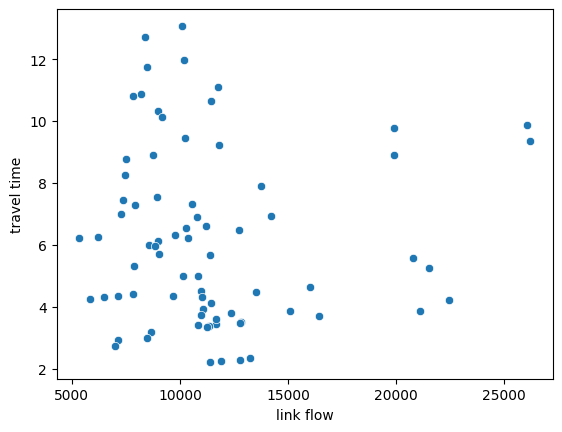

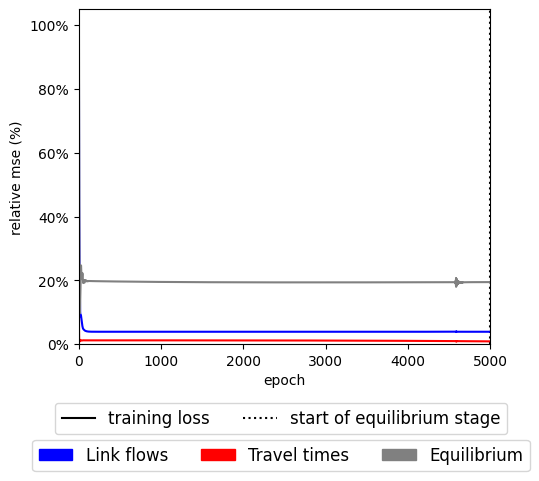

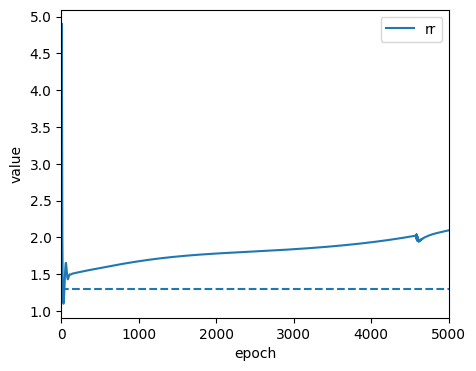

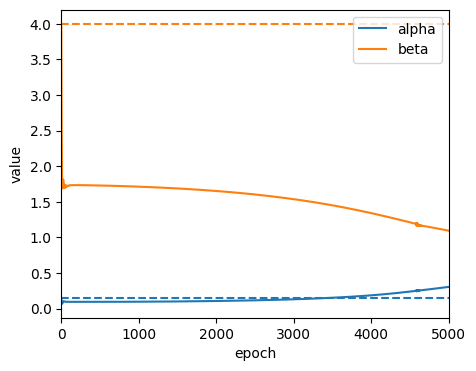

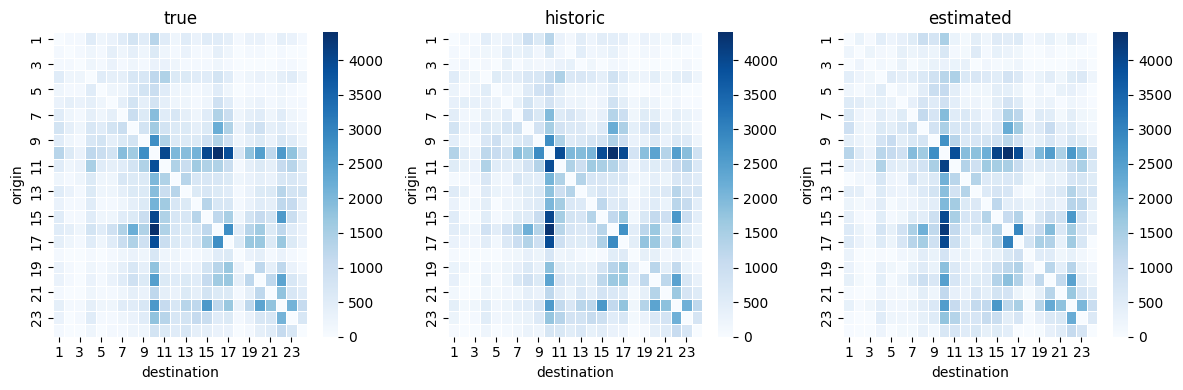

In [25]:
if run_model['odlulptte']:

    # To report runtime
    t0 = time.time()

    print('\nODLULPTTE: ODLULPE with no equilibrium component')

    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=_LR)

    bpr_parameters = BPRParameters(keys=['alpha', 'beta'],
                                   initial_values={'alpha': 0.15, 'beta': 4},
                                   true_values={'alpha': 0.15, 'beta': 4},
                                   trainables={'alpha': True, 'beta':True},
                                   )

    bpr_parameters.random_initializer((0,0),['alpha','beta'])
    # bpr_parameters.random_initializer((-0.15, 0.15), ['alpha'])

    od_parameters = ODParameters(key='od',
                                 initial_values=isl.networks.denseQ(Q).flatten(),
                                 historic_values={0: isl.networks.denseQ(Q_historic).flatten()},
                                 trainable=True)

    utility_parameters = UtilityParameters(features_Y=['tt'],
                                           features_Z=features_Z,
                                           initial_values={'tt': 0, 'tt_sd': 0, 's': 0, 'psc_factor': 0,
                                                           'fixed_effect': np.zeros_like(tntp_network.links)},
                                           true_values={'tt': -1, 'tt_sd': -1.3, 's': -3},
                                           # signs={'tt': '-', 'tt_sd': '-', 's': '-'},
                                           trainables={'psc_factor': False, 'fixed_effect': False
                                               , 'tt': True, 'tt_sd': True, 's': True},
                                           )

    utility_parameters.random_initializer((0,0),['tt','tt_sd','s'])
    # utility_parameters.initial_values = dict(utility_parameters.initial_values, tt = -1, c = -1, s = -1)

    odlulptte = PESUELOGIT(
        key='odlulptte',
        network=tntp_network,
        dtype=tf.float64,
        endogenous_flows=False,
        utility=utility_parameters,
        bpr=bpr_parameters,
        od=od_parameters,
    )

    train_results_dfs['odlulptte'], val_results_dfs['odlulptte'] \
        = odlulptte.train(
        X_train, Y_train, X_test, Y_test,
        optimizer=optimizer,
        batch_size=_BATCH_SIZE,
        loss_weights= dict(_LOSS_WEIGHTS, eq_flow = 0, bpr = 1),
        loss_metric=_LOSS_METRIC,
        threshold_relative_gap=_RELATIVE_GAP,
        epochs_print_interval=_EPOCHS_PRINT_INTERVAL,
        epochs= dict(_EPOCHS, equilibrium = 0)
    )

    train_results_estimates, train_results_losses \
        = odlulptte.split_results(results=train_results_dfs['odlulptte'])
    val_results_estimates, val_results_losses \
        = odlulptte.split_results(results=val_results_dfs['odlulptte'])

    sns.scatterplot(data = pd.DataFrame({'link flow': odlulptte.predicted_flow().numpy().flatten(),
                                         'travel time': odlulptte.predicted_traveltime().numpy().flatten(),
                                         # 'capacity': [link.bpr.k for link in odlulptte.network.links]
                                         }),
                                        x = 'link flow', y = 'travel time')

    plot_predictive_performance(train_losses= train_results_losses,
                                val_losses =val_results_dfs['odlulptte'],
                                epochs_end_learning_stage=_EPOCHS['learning'],
                                xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=
                               train_results_estimates.assign(
                                   rr = train_results_estimates['tt_sd']/train_results_estimates['tt'])[['epoch','rr']],
                               true_values={'rr':odlulptte.utility.true_values['tt_sd']
                                                 /odlulptte.utility.true_values['tt']},
                               xticks_spacing = _XTICKS_SPACING)

    plot_convergence_estimates(estimates=train_results_estimates[['epoch','alpha','beta']],
                               true_values=odlulptte.bpr.true_values,
                               xticks_spacing = _XTICKS_SPACING)

    Qs = {'true': tntp_network.OD.Q_true, 'historic': Q_historic, 'estimated': tf.sparse.to_dense(odlulptte.Q).numpy()}

    plot_heatmap_demands(Qs=Qs, vmin=np.min(Qs['true']), vmax=np.max(Qs['true']), subplots_dims=(1, 3), figsize=(12, 4))

    print(f"\ntheta = {dict(zip(utility_parameters.true_values.keys(), list(np.round(odlulptte.theta.numpy().flatten(),2))))}, "
          f"rr = {train_results_estimates.eval('tt_sd/tt').values[-1]:0.2f}")
    print(f"alpha = {np.mean(odlulptte.alpha): 0.2f}, "
          f"beta  = {np.mean(odlulptte.beta): 0.2f}")
    print(f"Avg abs diff between observed and estimated OD: "
          f"{np.mean(np.abs(odlulptte.q - tntp_network.q.flatten())): 0.2f}")

    print('\nMSE')
    print(f"training_error_flow={mse(actual=odlulptte.observed_flows, predicted = odlulptte.predicted_flow()):0.1f}, "
      f"training_error_traveltime={mse(actual=odlulptte.observed_traveltimes, predicted = odlulptte.predicted_traveltime()):0.1f}")
    print(compute_insample_outofsample_error(Y=Y_train,
                                         true_counts=df.true_counts.values[0:tntp_network.get_n_links()],
                                         true_traveltimes=df.true_traveltime.values[0:tntp_network.get_n_links()],
                                         model=odlulptte,
                                         metric = mse))

    print('\nMAPE')
    print(f"training_error_flow={mape(actual=odlulptte.observed_flows, predicted = odlulptte.predicted_flow()):0.1f}, "
      f"training_error_traveltime={mape(actual=odlulptte.observed_traveltimes, predicted = odlulptte.predicted_traveltime()):0.1f}")
    print(compute_insample_outofsample_error(Y=Y_train,
                                     true_counts=df.true_counts.values[0:tntp_network.get_n_links()],
                                     true_traveltimes=df.true_traveltime.values[0:tntp_network.get_n_links()],
                                     model=odlulptte,
                                     metric = mape))

    print(f'runtime: {time.time()-t0:0.1f} [s]')

## Write predictions

In [26]:
predictions = pd.DataFrame({'link_key': list(tntp_network.links_keys) * Y_train.shape[0],
                            'observed_traveltime': Y_train[:, :, 0].numpy().flatten(),
                            'observed_flow': Y_train[:, :, 1].numpy().flatten()})

predictions['period'] = df.period

for model in [lue,ode, odlue,odlulpe,odlulptte]:

    predicted_flows = model.flows()
    predicted_traveltimes = model.traveltimes()

    predictions['predicted_traveltime_' + model.key] = np.tile(predicted_traveltimes, (Y_train.shape[0], 1)).flatten()
    predictions['predicted_flow_' + model.key] = np.tile(predicted_flows, (Y_train.shape[0], 1)).flatten()

predictions.to_csv(f"./output/tables/{datetime.now().strftime('%y%m%d%H%M%S')}_train_predictions_{network_name}.csv")

## Write with estimation results

In [27]:
train_results_df, val_results_df \
    = map(lambda x: pd.concat([results.assign(model = model)[['model'] + list(results.columns)]
                               for model, results in x.items()],axis = 0), [train_results_dfs, val_results_dfs])

train_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_train_results_{network_name}.csv"
val_filename = f"{datetime.now().strftime('%y%m%d%H%M%S')}_validation_results_{network_name}.csv"
train_results_df.to_csv(f"./output/tables/{train_filename}")
print(f'File {train_filename} was written')
val_results_df.to_csv(f"./output/tables/{val_filename}")
print(f'File {val_filename} was written')

File 231028114649_train_results_SiouxFalls.csv was written
File 231028114649_validation_results_SiouxFalls.csv was written


## Summary of models parameters

In [28]:
models = [lue,odlue,odlulpe]
results = pd.DataFrame({'parameter': [], 'model': []})

for model in models:
    results = pd.concat([results,
                        pd.DataFrame(
                            {'parameter': ['tt'] + features_Z+
                                          ['rr']+
                                          ['fixed_effect_mean', 'fixed_effect_std',
                                           'alpha_mean', 'alpha_std',
                                           'beta_mean', 'beta_std',
                                           'od_mean', 'od_std',],
                             'values': list(np.mean(model.theta.numpy(),axis =0)) +
                                       [float(model.get_parameters_estimates().eval('tt_sd/tt'))] +
                                       [np.mean(model.fixed_effect),np.std(model.fixed_effect),
                                        np.mean(model.alpha),np.std(model.alpha),
                                        np.mean(model.beta),np.std(model.beta),
                                        np.mean(model.q),np.std(model.q)]}).
                        assign(model = model.key)
                             ])

/var/folders/mg/t5yt0b_d1cg4ykytg0c22xcc0000gn/T/ipykernel_75784/3158691949.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  [float(model.get_parameters_estimates().eval('tt_sd/tt'))] +
/var/folders/mg/t5yt0b_d1cg4ykytg0c22xcc0000gn/T/ipykernel_75784/3158691949.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  [float(model.get_parameters_estimates().eval('tt_sd/tt'))] +
/var/folders/mg/t5yt0b_d1cg4ykytg0c22xcc0000gn/T/ipykernel_75784/3158691949.py:14: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  [float(model.get_parameters_estimates().eval('tt_sd/tt'))] +


In [29]:
results.pivot_table(index = ['parameter'], columns = 'model', values = 'values', sort=False).round(4)

model,lue,odlue,odlulpe
parameter,,,
tt,-0.8768,-0.5398,-0.6496
tt_sd,-1.4297,-0.6292,-1.2956
s,-2.6119,-2.4590,-2.4350
rr,1.6305,1.1657,1.9946
fixed_effect_mean,0.0000,0.0000,0.0000
fixed_effect_std,0.0000,0.0000,0.0000
alpha_mean,0.1500,0.1500,0.1830
alpha_std,0.0000,0.0000,0.0000
beta_mean,4.0000,4.0000,3.7722


## Summary of models goodness of fit

In [30]:
results_losses = pd.DataFrame({})
loss_columns = ['loss_flow', 'loss_tt', 'loss_eq_flow', 'loss_total']

for i, model in enumerate(models):

    results_losses_model = model.split_results(train_results_dfs[model.key])[1].assign(model = model.key)
    results_losses_model = results_losses_model[results_losses_model.epoch == _EPOCHS['learning']].iloc[[0]]
    results_losses = pd.concat([results_losses,results_losses_model])

results_losses[loss_columns] = (results_losses[loss_columns]-1)*100

In [31]:
results_losses[['model'] + loss_columns].round(1)

,model,loss_flow,loss_tt,loss_eq_flow,loss_total
5000,lue,-91.1,-100.0,-100.0,-99.5
5000,odlue,-91.2,-100.0,-100.0,-99.7
5000,odlulpe,-91.2,-100.0,-100.0,-99.7


## Plot of convergence toward true rr across models

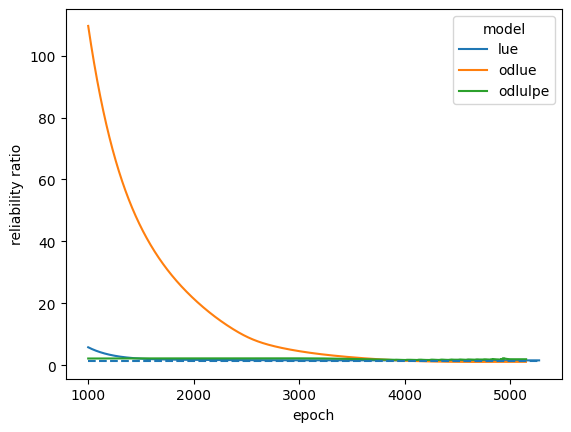

In [32]:
models = [lue,odlue,odlulpe]

train_estimates = {}
train_losses = {}

for model in models:
    train_estimates[model.key], train_losses[model.key] = model.split_results(results=train_results_dfs[model.key])

    train_estimates[model.key]['model'] = model.key

train_estimates_df = pd.concat(train_estimates.values())

train_estimates_df['rr'] = train_estimates_df['tt_sd']/train_estimates_df['tt']

estimates = train_estimates_df[['epoch','model','rr']].reset_index().drop('index',axis = 1)
estimates = estimates[estimates.epoch >=1000]

fig, ax = plt.subplots(nrows=1, ncols=1)

g = sns.lineplot(data=estimates, x='epoch', hue='model', y='rr')

ax.hlines(y=compute_rr(utility_parameters.true_values), xmin=estimates['epoch'].min(), xmax=estimates['epoch'].max(), linestyle='--', label = 'truth')

ax.set_ylabel('reliability ratio')

ax.set_xticks(np.arange(estimates['epoch'].min(), estimates['epoch'].max() + 1, _XTICKS_SPACING))

#ax.set_yscale('log')
#plt.ylim(ymin=0)
plt.show()

## Global runtime

In [33]:
print(f'runtime: {time.time()-t0_global:0.1f} [s]')

runtime: 5718.5 [s]
